# Demo Notebook

This notebook demonstrates how to extract/save keypoint-features from images and do single image inference with a feature database to find the best match.

# Import Libraries

Mount to Google Drive and download LightGlue Library

In [ ]:
# Existing Libraries
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

Mounted at /content/drive
/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


In [ ]:
from lightglue import LightGlue, SIFT
from lightglue.utils import load_image
import torch
import numpy as np
from scipy.stats import wasserstein_distance # Will need this if we use wasserstein
import re
import time
import pickle


torch.set_grad_enabled(False)

# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

# Keypoint Extraction

Extract keypoints for an image-set in a CSV-file and save the features in a dicitonary.

Load the CSV-file from which to load the images

In [ ]:
tab_filepath = '/content/drive/..'

split_df = pd.read_csv(tab_filepath)

In [ ]:
def extract_features(df, set, feature_extractor="superpoint", n_keypoints=1024): # possible hyperparameters
  feature_dict = {}

  if feature_extractor == 'superpoint':
    extractor = SuperPoint(max_num_keypoints=n_keypoints).eval().to(device)  # load the extractor

  elif feature_extractor == 'sift':
    extractor = SIFT(max_num_keypoints=n_keypoints).eval().to(device)  # load the extractor

  elif feature_extractor == 'disk':
    extractor = DISK(max_num_keypoints=n_keypoints).eval().to(device)  # load the extractor
    matcher = LightGlue(features="disk").eval().to(device)

  elif feature_extractor == 'aliked':
    extractor = ALIKED(max_num_keypoints=n_keypoints).eval().to(device)  # load the extractor
    matcher = LightGlue(features="aliked").eval().to(device)

  else:
    print("Unrecognised FeatureExtractionMethod... using superpoint instead")
    FeatureExtractionMethod= 'superpoint'
    extractor = SuperPoint(max_num_keypoints=n_keypoints).eval().to(device)  # load the extractor

  # only extract features for wanted split-set (train/test/val)
  sub_df = df[df["split"] == set]

  s = time.time()
  for _, row in sub_df.iterrows():

    # ADAPT TO OWN CSV STRUCTURE
    file_name = str(row['year']) + "/" + row['name'] # year folder and file name

    seg_path = "/content/drive/PATH_TO_IMAGES"

    actual_path = glob(seg_path + file_name + "*") # find image path + file ending

    if actual_path:
      image = load_image(actual_path[0]).to(device)
      features = extractor.extract(image)

      feature_dict[file_name] = features
  e = time.time()

  print(f"nr ims extracted: {len(feature_dict)}, time total: {e - s}")

  return feature_dict

Save and extraction configurations

In [ ]:
save_path = '/content/drive/PATH_TO_SAVE'
extractor = "sift"
n_kpts = 1024

Extract features and save as .pth at desired location

In [ ]:
train_dict = extract_features(split_df, set="train", feature_extractor=extractor, n_keypoints=n_kpts)
train_dict = feature_dict_to_device(train_dict, "cpu")  # move feature tensors to CPU before saving
torch.save(train_dict, f"{save_path}/train_{extractor}_{n_kpts}.pth")

# Load your image
How this works...
* This requires you to grant access to the shared google drive AI for Turtles via your google credentials (should be done already)
* What you need to change is the ImageFilepath

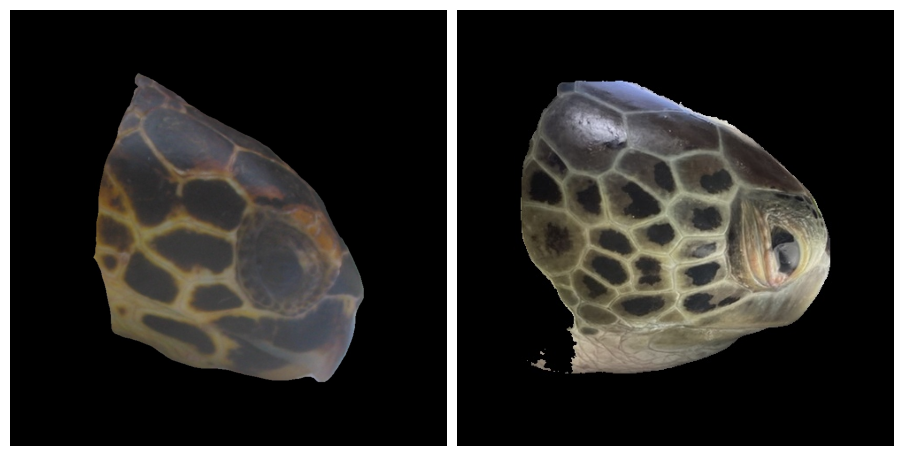

In [ ]:
# Match Example
ImageFilepath_Match = "/content/drive/.shortcut-targets-by-id/1VFaqKD8phZA1Glpw68_hY8wksUrX5Rn8/Example_SingleImageMock/2006_06-104 R.jpg"
#ImageFilepath_Match = "/content/drive/.shortcut-targets-by-id/1VFaqKD8phZA1Glpw68_hY8wksUrX5Rn8/Example_SingleImageMock/2021_19-006 R.jpg"

# Novel Example
ImageFilepath_Novel = "/content/drive/.shortcut-targets-by-id/1VFaqKD8phZA1Glpw68_hY8wksUrX5Rn8/Example_SingleImageMock/2023_23-107 R.jpg"

# Visualise to check
from lightglue import viz2d
InputImage_Match = load_image(ImageFilepath_Match)
InputImage_Novel = load_image(ImageFilepath_Novel)
viz2d.plot_images([InputImage_Match, InputImage_Novel])

# Utils

In [ ]:
def label_from_path(path):
  '''
    Extract year, number, and side (if available) from the filename

    Args:
      path (str) : path to extract label from

    Returns:
      _ (str) : ID of format [YY]-[Turtle Nr] [L/R]
  '''

  match = re.search(r'(\d{2})-(\d+)', path)

  if match:
      year, number = match.groups()

      # Check for capital 'L' or 'R' in the filename
      side_match = re.search(r'[LR]', path)

      if side_match:
          side = side_match.group()
      else:
          # If capital 'L' or 'R' not found, check for lowercase 'l' or 'r'
          side_match = re.search(r'[lr]', path)
          side = side_match.group().upper() if side_match else ''

      # Create a new filename based on the specified format
      return f"{year}-{number} {side}"

In [ ]:
def feature_dict_to_device(f_dict, device):
  '''
    Sends a dicitonary with tensors as values to a certain device

    Args:
      f_dict: Dictionary with tensors as values
      device: Device to send the dictionary to

    Returns:
      f_dict (dict): Same dictionary on different device
  '''
  for key in f_dict:
    temp_dict = {}

    for f_key in f_dict[key]:
      temp_dict[f_key] = f_dict[key][f_key].to(device)
    f_dict[key] = temp_dict

  return f_dict

In [ ]:
def divide_list(original_list, N):
  '''
  Divides a given list into sublists of size N approximately.

  Args:
    original_list (list): The list to be divided.
    N (int): Size of sublists.

  Returns:
    list: List of sublists where each sublist, except the last one, has N elements.
          The last sublist may have fewer elements if the length of original_list is not divisible by N.
  '''

  num_sublists = len(original_list) // N
  remainder = len(original_list) % N

  sublists = [original_list[i * N:(i + 1) * N] for i in range(num_sublists)]

  if remainder > 0:
      sublists.append(original_list[-remainder:])

  return sublists

In [ ]:
from itertools import compress

def batch_by_dict(feature_dict, labels, max_batch_size=32):
  '''
  Batches a given feature dictionary according to Keypoint length and a given batch size
  Within a single batch, every feature has the same number of keypoints. The batches are of
  the given size, unless not possible

  Args:
    feature_dict : dictionary of features: Key - path from data root, Value - keypoints + descriptors

  Returns:
    batch_list (list) : list of dicitonaries, where every dictionary is a single batch
    label_list (list) : re-ordered list of lables according to the batching process
  '''
  kpt_len = np.array([len(feature['keypoints'][0]) for feature in feature_dict.values()])

  feature_list = feature_dict.values()
  label_list = []
  batch_list = []
  for n_kpt in set(kpt_len):
    sub_feat = list(compress(feature_list, kpt_len == n_kpt))
    sub_labels = list(compress(labels, kpt_len == n_kpt))

    # if size of subset > batch size, split into smaller batches
    bs_sub_feat = divide_list(sub_feat, max_batch_size)
    bs_sub_labels = divide_list(sub_labels, max_batch_size)

    for bs_feat, bs_labels in zip(bs_sub_feat, bs_sub_labels):
      new_dict = {}
      for key in bs_feat[0].keys():
        new_dict[key] = []

      for feat in bs_feat:
        for key in feat.keys():
          new_dict[key].append(feat[key])

      for key in new_dict:
        new_dict[key] = torch.concat(new_dict[key])

      batch_list.append(new_dict)
      label_list += bs_labels

  return batch_list, label_list

In [ ]:
import numpy as np
fpath_base = "/content/drive/.shortcut-targets-by-id/14M23_ygiJ6LB0JpUgESZxLyWOQQjp60h/LightGlue_Implementations/WassersteinDistributions/"
def import_distributions(fpath_base,method='superpoint'):
  # Import pre-saved score distributions for non-matches (x0) and matches (x1)
  if method == 'disk':
    f0 = 'x0_disk.npy'
    f1 = 'x1_disk.npy'
  elif method == 'superpoint':
    f0 = 'x0_superpoint.npy'
    f1 = 'x1_superpoint.npy'
  elif method == 'aliked':
    f0 = 'x0_aliked.npy'
    f1 = 'x1_aliked.npy'
  elif method == 'sift':
    f0 = 'x0_sift.npy'
    f1 = 'x1_sift.npy'

  fp0 = fpath_base + f0
  fp1 = fpath_base + f1

  x0 = np.load(fp0)
  x1 = np.load(fp1)
  return x0, x1

# Single Inference

## Scoring and Prediction Functions

In [ ]:

def matching_score(match_out, method="score10", x0=[], batch_index=0):
  '''
  Given a LightGlue output for a matching pair, return the score for the current pair

  Args:
    match-out (dict): output of LightGlue -

          Output (dict):
              log_assignment: [B x M+1 x N+1]
              matches0: [B x M] - matched keypoints for im0
              matching_scores0: [B x M] - scores for all im0 keypoints
              matches1: [B x N] - matched keypoints for im1
              matching_scores1: [B x N] - scores for all im1 keypoints
              matches: List[[Si x 2]] - index-tuple list of matched keypoints
              scores: List[[Si]] - scores for each match-tuple

    method (str): the method of extraction
      'score10/25/50': Sum of the highest 10/25/50 confidence scores for matched keypoints
      'wasserstein_h0': The scipy function wasserstein_distance
      'wasserstein_h1': The scipy function wasserstein_distance, but ammended to be 1-wasserstein
    x0 (list): the distribution that we are comparing to
  '''

  match_scores = match_out["scores"][batch_index]
  im0_scores = match_out["matching_scores0"][batch_index]

  # top 10 matched keypoint scores summed
  if method == "score10":
    return match_scores.sort(descending=True)[0][:min(len(match_scores), 10)].sum()

  # top 25 matched keypoint scores summed
  elif method == "score25":
    return match_scores.sort(descending=True)[0][:min(len(match_scores), 25)].sum()

  # top 50 matched keypoint scores summed
  elif method == "score50":
    return match_scores.sort(descending=True)[0][:min(len(match_scores), 50)].sum()

  # ------------
  # add Wasserstein_h0 here
  elif method == "wassersteinH0":
    return wasserstein_distance(x0, im0_scores.to("cpu"))

  # add Wasserstein_h1 here - this compares to a matched distribution (i.e. small wasserstein = match)
  elif method == "wassersteinH1":
    return 1 - wasserstein_distance(x0, im0_scores.to("cpu"))
  # ------------

  else:
    print("Unviable method argument. Defaulting to total number of matches.")
    return match_scores.sort(descending=True)[0][:min(len(match_scores), 10)].sum()


def predict(score, labels, topN=5, metric='Highest'):
  '''
  Returns the top N predicted (unique) turtle IDs based on an array of scores

  Args:
    score - array of scores for current image against whole reference set
    labels - list of turtle IDs corresponding to each score
    topN - top N predictions to return
    metric - what metric you are using (most use the largest score, apart from wassersteinH1

  Returns:
    _ (list): top N unique turtle IDs
    _ (list): scores associated with each turtle ID in the top N
  '''

  score, labels = np.array(score), np.array(labels)
  indices = np.argsort(score) #  default asc
  if metric == 'wassersteinH1':
    score_dict = {label: s for label, s in zip(labels[indices[::-1]], score[indices[::-1]])} # only minimum scores for each label
    reverse = False # ascending order

  else:
    score_dict = {label: s for label, s in zip(labels[indices], score[indices])} # only maximum scores for each label
    reverse = True # descending order

  sorted_items = sorted(score_dict.items(), key=lambda x: x[1], reverse=reverse) # sort by score
  topN_items = sorted_items[:topN]

  return [item[0] for item in topN_items], [item[1] for item in topN_items]


def predict_NewTurtle(dist, val, thresh):
  '''
  Based on the maximum h0 score this predicts the probability that the turtle is not a match

  Inputs
  dist - The model distribution ("/content/drive/.shortcut-targets-by-id/14M23_ygiJ6LB0JpUgESZxLyWOQQjp60h/LightGlue_Implementations/NewTurtle_H1scores.sav")
  val - The maximum H0 score from all the comparisons
  thresh - A threshold where if the p value is greater then true

  Outputs
  p - The probability that the turtle is a new turtle (not part of the dataset). 1 - the integral of the distribution.
  pred_New - Boolean on whether the turtle is new or not
  '''
  p = 1 - dist.integrate_box_1d(0, val)
  pred_New = p > thresh
  return p, pred_New

In [ ]:
fpath_base_W = "/content/drive/.shortcut-targets-by-id/14M23_ygiJ6LB0JpUgESZxLyWOQQjp60h/LightGlue_Implementations/WassersteinDistributions/"
novel_path = '/content/drive/.shortcut-targets-by-id/14M23_ygiJ6LB0JpUgESZxLyWOQQjp60h/LightGlue_Implementations/'
save_path = '/content/drive/.shortcut-targets-by-id/1duwYN4CyEW2al2kOiQpuv8Wdnsnt06MA/LightGlue_Keypoints/'

def single_im_inference(new_impath, face_side, matcher, extractor, config, topN=5):
  '''
  Perform inference on a single image for face recognition or similarity matching.

  Args:
  - new_impath (str): File path to the new image.
  - face_side (str): Side of the face ('L' for left, 'R' for right).
  - matcher: Matcher object for matching.
  - extractor: Feature extractor object for extracting features.
  - config (dict): Configuration dictionary containing various settings.
  - topN (int, optional): Number of top matches to consider. Defaults to 5.

  Returns:
  - list: Predicted labels for the new image.
  - list: Predicted scores for matches.
  - bool: Indicates whether the image is considered new.
  - float: Probability of the image being new.
  - float: Time taken for image loading and feature extraction.
  - float: Time taken for matching.
  '''

   # define features
  train_dict_L = torch.load(f"{save_path}trainL_{config['extractor']}_{config['n_kpts']}.pth")
  train_dict_R = torch.load(f"{save_path}trainR_{config['extractor']}_{config['n_kpts']}.pth")

  # to device
  train_dict_L = feature_dict_to_device(train_dict_L, device)
  train_dict_R = feature_dict_to_device(train_dict_R, device)

  # reference set labels
  turtles_in_trainL = [label_from_path(im_path) for im_path in train_dict_L]
  turtles_in_trainR = [label_from_path(im_path) for im_path in train_dict_R]

  # define batches and sort labels accordingly
  batch_list_L, turtles_in_trainL = batch_by_dict(train_dict_L, turtles_in_trainL, max_batch_size=64)
  batch_list_R, turtles_in_trainR = batch_by_dict(train_dict_R, turtles_in_trainR, max_batch_size=64)

  # import reference distributions
  x0, x1 = import_distributions(fpath_base_W, method=config['extractor'])

  # import #1-score PDF for novelty detection
  novelty_dist = pickle.load(open(novel_path + 'NewTurtle_H1scores.sav', 'rb'))

  # load image and extract features
  t_s = time.time()
  image = load_image(new_impath).to(device)
  nb_feat0 = extractor.extract(image)
  t_e = time.time()
  time_load_extract = t_e - t_s

  # define scoring function
  metric = config["metric"]
  if metric == 'wassersteinH0':
    scoring_function = lambda out, i: matching_score(out, method=metric, x0=x0, batch_index=i)
  elif metric == 'wassersteinH1':
    scoring_function = lambda out, i: matching_score(out, method=metric, x0=x1, batch_index=i)
  else:
    scoring_function = lambda out, i: matching_score(out, method=metric, batch_index=i)

  # only search left/right reference set
  print(face_side)
  batch_list, turtles_in_train =  (batch_list_L, turtles_in_trainL) if face_side == "L" else (batch_list_R, turtles_in_trainR)

  scores = []
  nr_matches = []
  # match
  t_s = time.time()
  for batch in batch_list:
    batch_size = batch['keypoints'].shape[0]

    feat1 = batch # get feature dictionary

    # reformat feat0 to fit batch
    feat0 = {}
    for key in nb_feat0:
      feat0[key] = torch.concat([nb_feat0[key]] * batch_size)

    matches = light_glue({"image0": feat0, "image1": feat1})

    for i in range(batch_size):
      # obtain scores
      score = scoring_function(matches, i)
      scores.append(score.item())

      # nr of matched keypoints
      nr_matches.append(len(matches["matches"][i]))

  # predict
  # top 5 matches
  predicted_label, predicted_scores = predict(scores, turtles_in_train, metric=metric)

  # new turtle condition
  novelty_thresh = config["novelty_thresh"]
  p_new, is_new = predict_NewTurtle(novelty_dist, predicted_scores[0], novelty_thresh)

  t_e = time.time()
  match_time = t_e - t_s

  return predicted_label, predicted_scores, is_new, p_new, time_load_extract, match_time


In [ ]:
#Configs
extractor = SIFT(max_num_keypoints=1024).eval().to(device)
config = {"extractor" :  "sift",
          "n_kpts" : 1024,
          "n_layers" : 9,
          "metric" : "wassersteinH0",
          "novelty_thresh" : 0.69}
feature_extractor = config["extractor"]
n_keypoints = config["n_kpts"]
lg_n_layers = config["n_layers"]

light_glue = LightGlue(features=feature_extractor,
                          n_layers=lg_n_layers,
                            width_confidence=-1, # disable for batching
                            depth_confidence=-1).eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/sift_lightglue.pth" to /root/.cache/torch/hub/checkpoints/sift_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 361MB/s]


#### LightGlue Hyperparameters ####
```
default_conf = {
        "name": "lightglue",  # just for interfacing
        "input_dim": 256,  # input descriptor dimension (autoselected from weights)
        "descriptor_dim": 256,
        "add_scale_ori": False,
        "n_layers": 9, #From my memory we usually exit way before all 9 layers are used
        "num_heads": 4,
        "flash": True,  # enable FlashAttention if available.
        "mp": False,  # enable mixed precision
        "depth_confidence": 0.95,  # early stopping, disable with -1; DISABLE FOR BATCH PROCESSING
        "width_confidence": 0.99,  # point pruning, disable with -1; DISABLE FOR BATCH PROCESSING
        "filter_threshold": 0.1,  # match threshold - none of our metrics use this apart from `nr_match` so we don't need to tune this.
        "weights": None,
    }
```

# Perform LightGlue

In [ ]:
#Matching Turtle
predicted_label, predicted_scores, is_new, p_new, time_load_extract, match_time = single_im_inference(ImageFilepath_Match, "R", light_glue, extractor, config, topN=5)
print(ImageFilepath_Match)
print("Predicted Labels: ",predicted_label)
print("Predicted Scores: ",predicted_scores)
print("Novel: ",is_new," p_val: ",p_new)
print("Time to load extracted features:", time_load_extract)
print("Matching Time: ",match_time)

#Create a dictionary
Results_Match = {'PredictedLabels': predicted_label,
           'PredictedScores': predicted_scores,
           'Novel': is_new,
           'Novel_p': p_new,
           'MatchingTime': match_time,
           'Image0':[],
           'Image1':[],
           'Image2':[],
           'Image3':[],
           'Image4':[]}

R
/content/drive/.shortcut-targets-by-id/1VFaqKD8phZA1Glpw68_hY8wksUrX5Rn8/Example_SingleImageMock/2006_06-104 R.jpg
Predicted Labels:  ['06-104 R', '06-014 R', '09-094 R', '13-135 R', '11-005 R']
Predicted Scores:  [0.7535287127733195, 0.03718749305390787, 0.02488441124052014, 0.02419514337123893, 0.02165211232533957]
Novel:  False  p_val:  0.022022453535780806
Time to load extracted features: 0.6980454921722412
Matching Time:  45.719486236572266


In [ ]:
#Novel Turtle
predicted_label, predicted_scores, is_new, p_new, time_load_extract, match_time = single_im_inference(ImageFilepath_Novel, "R", light_glue, extractor, config, topN=5)
print(ImageFilepath_Novel)
print("Predicted Labels: ",predicted_label)
print("Predicted Scores: ",predicted_scores)
print("Novel: ",is_new," p_val: ",p_new)
print("Time to load extracted features:", time_load_extract)
print("Matching Time: ",match_time)

#Create a dictionary
Results_Novel = {'PredictedLabels': predicted_label,
           'PredictedScores': predicted_scores,
           'Novel': is_new,
           'Novel_p': p_new,
           'MatchingTime': match_time,
           'Image0':[],
           'Image1':[],
           'Image2':[],
           'Image3':[],
           'Image4':[]}

R
/content/drive/.shortcut-targets-by-id/1VFaqKD8phZA1Glpw68_hY8wksUrX5Rn8/Example_SingleImageMock/2023_23-107 R.jpg
Predicted Labels:  ['23-107 R', '22-259 R', '18-021 R', '06-146 R', '21-154 R']
Predicted Scores:  [0.6875225499587893, 0.02404742077306044, 0.020773588724287848, 0.01849844101555272, 0.01741027987751989]
Novel:  False  p_val:  0.022022453535780806
Time to load extracted features: 0.4304780960083008
Matching Time:  44.12083601951599


#User friendly visualisation of results
* Want to see scores and images of top 5 matches
* Value prediction of new or not

## Utils

In [ ]:
# Establish the base path for all the images
base_path = "/content/drive/.shortcut-targets-by-id/1XpUS4zHTo6vlS_lJvVOlT0dHnNwnZGI-/Dataset corrected image orientation face crops/"

In [ ]:
import os
def get_subfolders(base_path):
  folders = []
  paths = []
  layer = 1
  w = os.walk(base_path)
  for (dirpath, dirnames, filenames) in w:
      if layer == 1:
          folders.extend(dirnames)
          break
      layer += 1
  return folders

def find_images(base_path,label):
  ex = label + ".jpg" #I assume it will be a .jpg image
  folders = get_subfolders(base_path)
  filepaths = []
  for i,f in enumerate(folders):
    temp_dir = base_path + f + "/"
    temp_files = os.listdir(temp_dir)
    if ex in temp_files:
      fp = temp_dir + ex
      filepaths.append(fp)
  return filepaths

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def PlotResults(Results,ImageFilepath):
  InputImage = mpimg.imread(ImageFilepath)
  #Load the images into the results dictionary
  labels = Results['PredictedLabels']
  for i, label in enumerate(labels):
    filepaths = find_images(base_path,label)
    #Is this the same as the loaded image?
    if len(filepaths) > 1:
      Image_Label = mpimg.imread(filepaths[0]) #Just choosing the 2nd one for now. TO DO make this the most recent image of the turtle
    else: #Just take the first one
      Image_Label = mpimg.imread(filepaths[0])

    if i == 0:
      Results['Image0'] = Image_Label
    elif i == 1:
      Results['Image1'] = Image_Label
    elif i == 2:
      Results['Image2'] = Image_Label
    elif i == 3:
      Results['Image3'] = Image_Label
    elif i == 4:
      Results['Image4'] = Image_Label

  #Plot the images
  plt.figure(figsize=(24, 6))
  #Plot the new image
  ax_Input = plt.subplot(1,3,1)
  ax_Input.imshow(InputImage)
  ax_Input.set_axis_off()
  ax_Input.set_title('Loaded Image')

  #Plot the top 5 results
  ax_Match0 = plt.subplot(3,3,2)
  ax_Match0.imshow(Results['Image0'])
  tn = "{match}, {label}: {score:.3f}".format(
      match="Match 0",
      label=Results['PredictedLabels'][0],
      score=Results['PredictedScores'][0])
  ax_Match0.set_title(tn)
  ax_Match0.set_axis_off()

  ax_Match1 = plt.subplot(3,3,3)
  ax_Match1.imshow(Results['Image1'])
  tn = "{match}, {label}: {score:.3f}".format(
      match="Match 1",
      label=Results['PredictedLabels'][1],
      score=Results['PredictedScores'][1])
  ax_Match1.set_title(tn)
  ax_Match1.set_axis_off()

  ax_Match2 = plt.subplot(3,3,5)
  ax_Match2.imshow(Results['Image2'])
  tn = "{match}, {label}: {score:.3f}".format(
      match="Match 2",
      label=Results['PredictedLabels'][2],
      score=Results['PredictedScores'][2])
  ax_Match2.set_title(tn)
  ax_Match2.set_axis_off()

  ax_Match3 = plt.subplot(3,3,6)
  ax_Match3.imshow(Results['Image3'])
  tn = "{match}, {label}: {score:.3f}".format(
      match="Match 3",
      label=Results['PredictedLabels'][3],
      score=Results['PredictedScores'][3])
  ax_Match3.set_title(tn)
  ax_Match3.set_axis_off()

  ax_Match4 = plt.subplot(3,3,8)
  ax_Match4.imshow(Results['Image4'])
  tn = "{match}, {label}: {score:.3f}".format(
      match="Match 4",
      label=Results['PredictedLabels'][4],
      score=Results['PredictedScores'][4])
  ax_Match4.set_title(tn)
  ax_Match4.set_axis_off()

  #Now plot the novel prediction as a table
  if Results['Novel']:
    txt = "Yes"
  else:
    txt = "No"


  ax_Novel = plt.subplot(3,3,9)
  ax_Novel.text(0.25,0.9,"Prediction for New Turtle")
  ax_Novel.text(0.25,0.6,"New Turlte?: {pred}".format(pred = txt))
  ax_Novel.text(0.25,0.3,"p_val: {p_val:.3f}".format(p_val = Results['Novel_p']))
  ax_Novel.set_axis_off()

  return Results

## Result

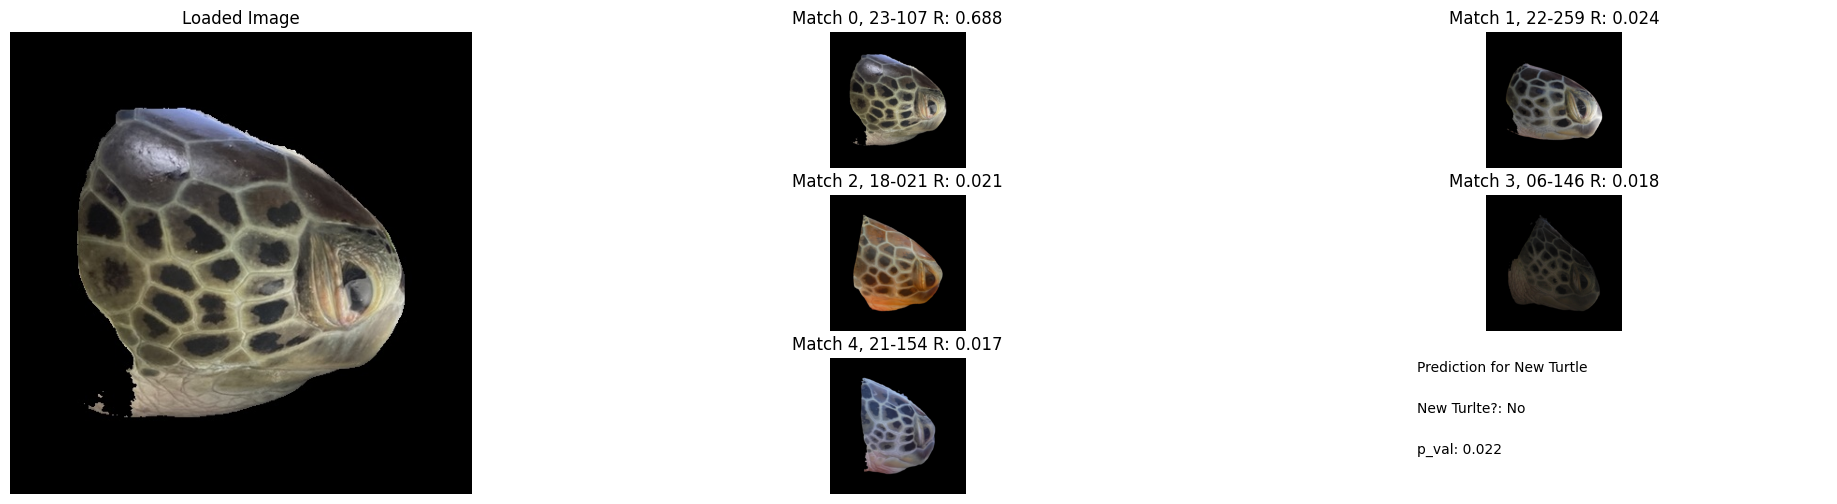

In [ ]:
Results_Novel = PlotResults(Results_Novel,ImageFilepath_Novel)

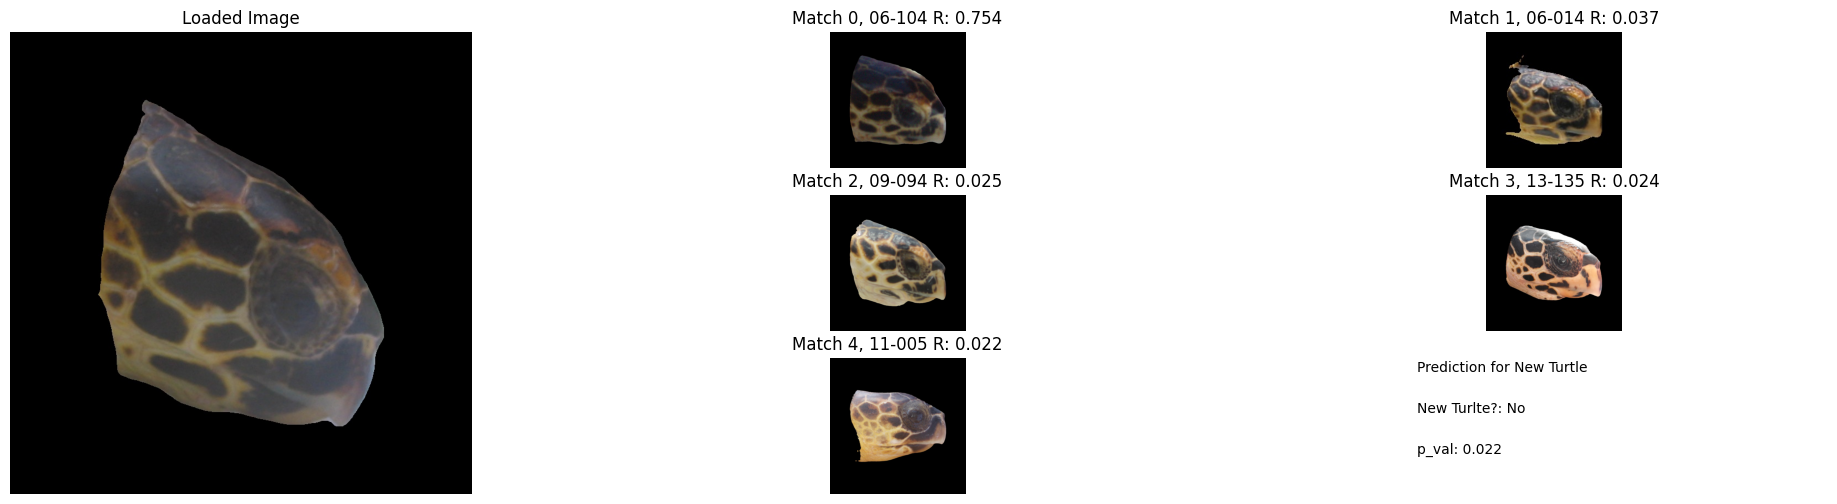

In [ ]:
Results_Match = PlotResults(Results_Match,ImageFilepath_Match)

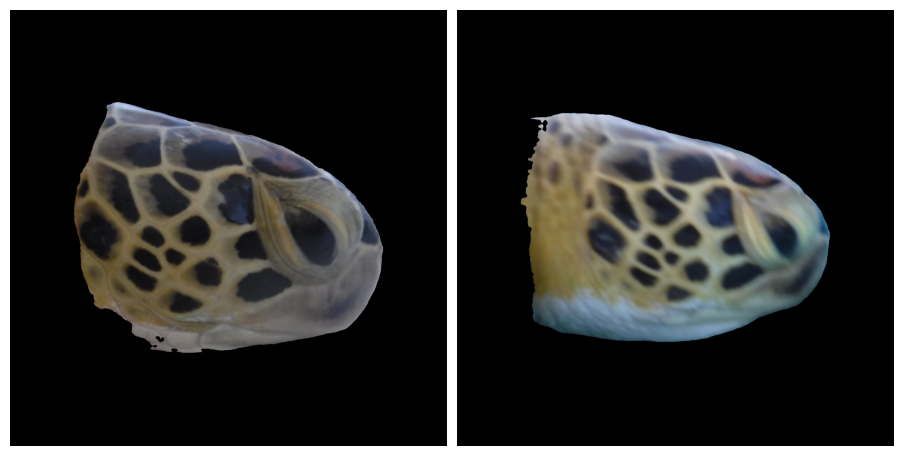

In [ ]:
viz2d.plot_images([InputImage_Match, Results_Match['Image0']])